In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "data/data"

DATA_ROOT = Path(data_path)




In [3]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

def normalize_eeg(x: np.ndarray) -> np.ndarray:
    """
    Normalize EEG signal between -1 and 1 per channel.

    Parameters:
    - x: EEG signal, shape (time, channels)

    Returns:
    - Normalized signal
    """
    min_vals = x.min(axis=0)
    max_vals = x.max(axis=0)
    return 2 * (x - min_vals) / (max_vals - min_vals + 1e-8) - 1 

from scipy.signal import hilbert
import numpy as np
from scipy.signal import resample

def downsample(x: np.ndarray) -> np.ndarray:
    
    
    # Resample the analytic signal to 300 samples
    downsampled_signal = resample(x, 300, axis=0)
    
    return downsampled_signal


In [4]:

data_root = Path(data_path)
clips_tr = pd.read_parquet(data_root / "train/segments.parquet")
ids = clips_tr["signals_path"].astype(str).tolist()
ids = list(map(lambda x: x[x.find("_") + 1 : x.find("_") + 5], ids))
clips_tr["subject_id"] = ids
clips_tr.head()
# calulate ratio bewteen label 0 and label 1 per unique subject
ratio = clips_tr.groupby("subject_id")["label"].value_counts(normalize=True).unstack()
print(ratio)
# print subject ids 
unique_subjects = clips_tr["subject_id"].unique()
print(unique_subjects)
# print number of clips per subject
print(clips_tr["subject_id"].value_counts())
# print the percentage of clips per subject
print(clips_tr["subject_id"].value_counts(normalize=True))
        

label              0         1
subject_id                    
s001        0.757630  0.242370
s002        0.831869  0.168131
s003        0.840773  0.159227
s004        0.810518  0.189482
s005        0.919028  0.080972
s006        0.837209  0.162791
s007        0.973913  0.026087
s008        0.854167  0.145833
s009        0.758929  0.241071
s010        0.811765  0.188235
s011        0.960784  0.039216
s015             NaN  1.000000
['s001' 's002' 's003' 's005' 's004' 's009' 's011' 's015' 's010' 's008'
 's006' 's007']
subject_id
s001    5046
s002    2504
s003    2173
s004    1198
s005     741
s006     430
s009     224
s008     192
s010     170
s011     153
s007     115
s015      47
Name: count, dtype: int64
subject_id
s001    0.388363
s002    0.192719
s003    0.167244
s004    0.092203
s005    0.057031
s006    0.033095
s009    0.017240
s008    0.014777
s010    0.013084
s011    0.011776
s007    0.008851
s015    0.003617
Name: proportion, dtype: float64


In [5]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=downsample,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)


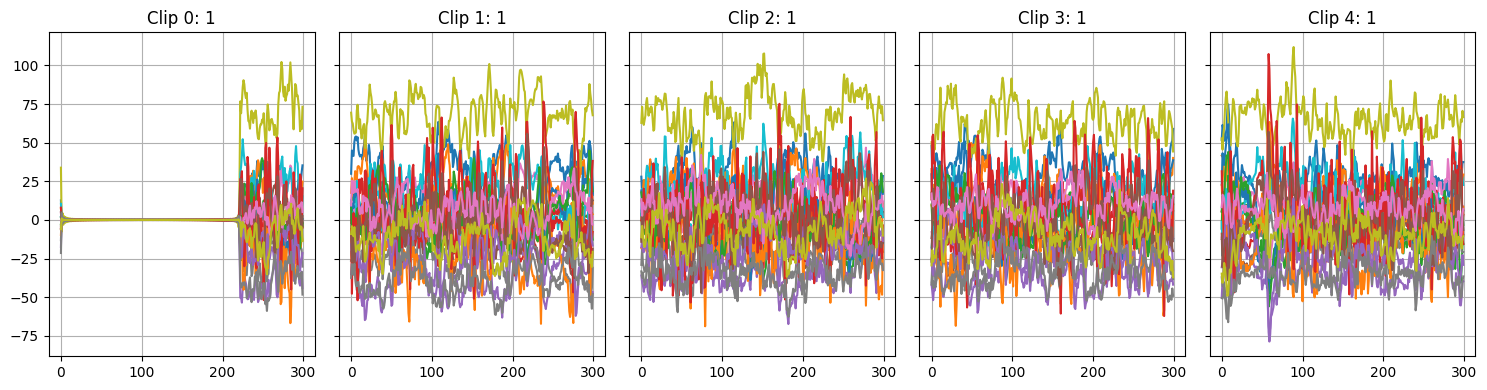

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()


In [7]:
# print the shape of the dataset
print(f"Dataset shape: {dataset_tr.__len__()}")
# print the shape of the first 10 clips
for i in range(10):
    x, y = dataset_tr[i]
    print(f"Clip {i} shape: {x.shape}, label: {y}")

Dataset shape: 12993
Clip 0 shape: (300, 19), label: 1
Clip 1 shape: (300, 19), label: 1
Clip 2 shape: (300, 19), label: 1
Clip 3 shape: (300, 19), label: 1
Clip 4 shape: (300, 19), label: 1
Clip 5 shape: (300, 19), label: 1
Clip 6 shape: (300, 19), label: 1
Clip 7 shape: (300, 19), label: 1
Clip 8 shape: (300, 19), label: 1
Clip 9 shape: (300, 19), label: 1


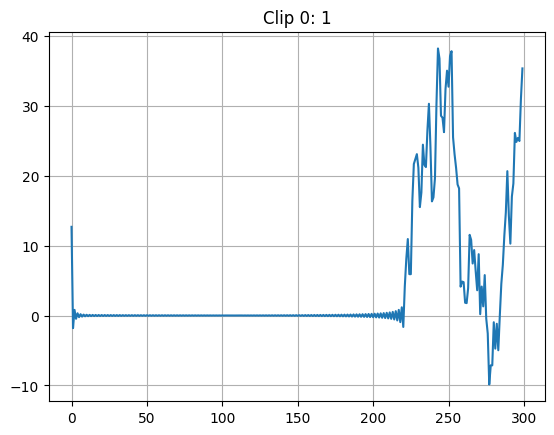

In [8]:
clip, y = dataset_tr[0]
#plot first channel
plt.plot(clip[:, 0])
plt.title(f"Clip 0: {y}")
plt.grid()
plt.show()


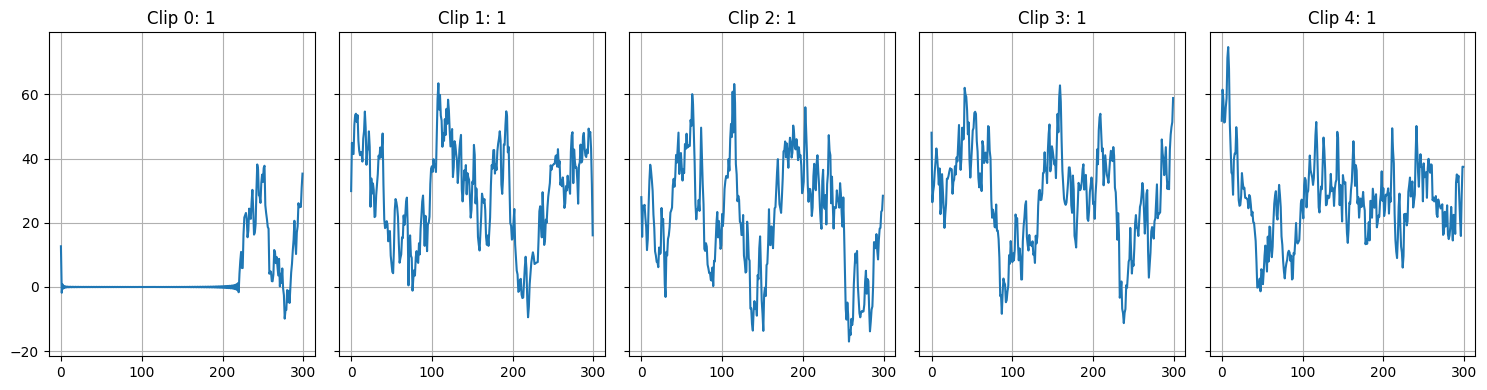

In [9]:
x = []
labels = []
for i in range(len(dataset_tr)):
    clip, y = dataset_tr[i]
    x.append(clip[:, 0])
    labels.append(y)
x = np.array(x)
labels = np.array(labels)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

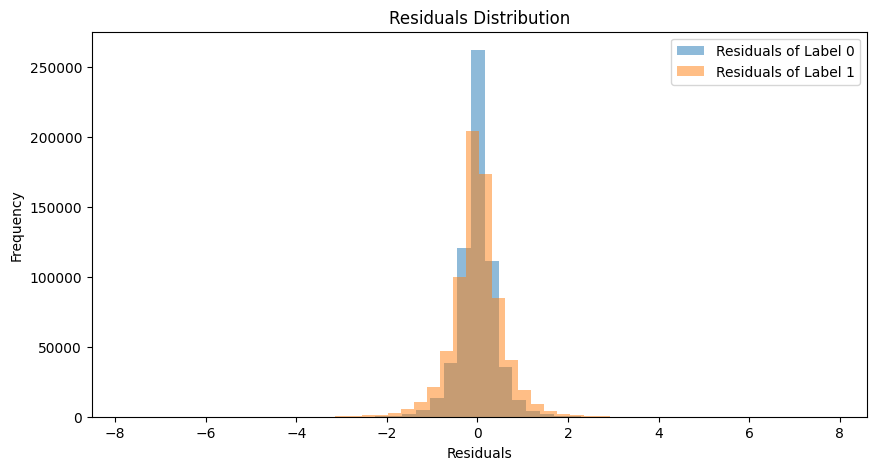

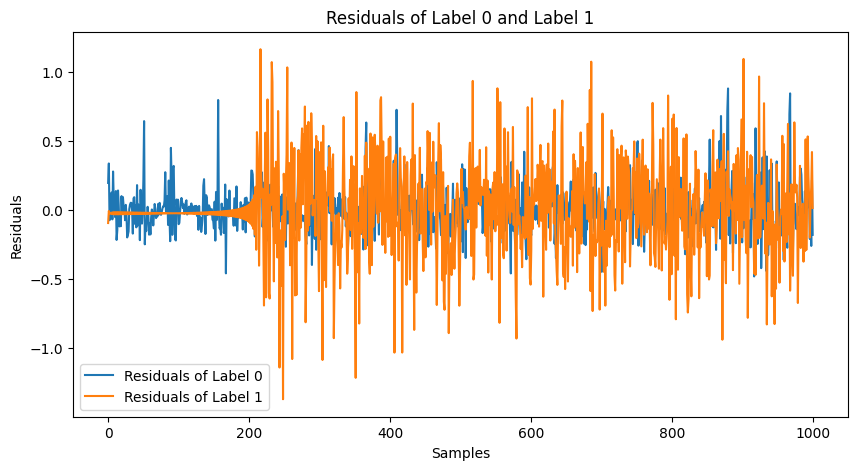

In [16]:
### train AR model on label == 0 data
from statsmodels.tsa.ar_model import AutoReg

# Get the data for label 0
label_0_data = x[labels == 0]
# split label_0_data train and test
train_size = int(len(label_0_data) * 0.8)
label_0_train = label_0_data[:train_size]
label_0_test = label_0_data[train_size:]
order_p = 10  # AR order
all_coeffs = []

for clip in label_0_train:
    # Handle NaN values and normalize
    clip = clip[~np.isnan(clip)]  # Remove NaN values
    if len(clip) > order_p:  # Ensure the clip length is greater than the AR order
        clip = (clip - np.mean(clip)) / (np.std(clip) + 1e-8)  # Normalize
        model = AutoReg(clip, lags=order_p).fit()
        coeffs = model.params[1:]  # Skip intercept
        all_coeffs.append(coeffs)

# Average coefficients across clips
avg_coeffs = np.mean(np.stack(all_coeffs), axis=0)

# test the model on label 0 test data
residual_0 = []
for clip in label_0_test:
    # Handle NaN values and normalize
    clip = clip[~np.isnan(clip)]  # Remove NaN values
    if len(clip) > order_p:  # Ensure the clip length is greater than the AR order
        clip = (clip - np.mean(clip)) / (np.std(clip) + 1e-8)  # Normalize
        model = AutoReg(clip, lags=order_p).fit()
        residual_0.append(model.resid)
# test model on label 1 data
label_1_data = x[labels == 1]
residual_1 = []
for clip in label_1_data:
    # Handle NaN values and normalize
    clip = clip[~np.isnan(clip)]  # Remove NaN values
    if len(clip) > order_p:  # Ensure the clip length is greater than the AR order
        clip = (clip - np.mean(clip)) / (np.std(clip) + 1e-8)  # Normalize
        model = AutoReg(clip, lags=order_p).fit()
        residual_1.append(model.resid)
# plot residuals distribution histogram of residual_0 and residual_1
# reshape residual_0 and residual_1 to 1D
residual_0 = np.concatenate(residual_0).ravel()
residual_1 = np.concatenate(residual_1).ravel()
plt.figure(figsize=(10, 5))
plt.hist(residual_0, bins=50, alpha=0.5, label="Residuals of Label 0")
plt.hist(residual_1, bins=50, alpha=0.5, label="Residuals of Label 1")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()
# plot first 1000 residuals of label 0 and label 1
plt.figure(figsize=(10, 5))
plt.plot(residual_0[:1000], label="Residuals of Label 0")
plt.plot(residual_1[:1000], label="Residuals of Label 1")
plt.title("Residuals of Label 0 and Label 1")
plt.xlabel("Samples")
plt.ylabel("Residuals")
plt.legend()
plt.show()


In [ ]:
# plot the acf for 5 random clips of label 0 and label 1
from statsmodels.graphics.tsaplots import plot_acf
import random

# Get 5 random clips from label 0 and label 1
label_0_clips = random.sample(list(label_0_data), 5)
label_1_clips = random.sample(list(label_1_data), 5)
# plot the acf for label 0 and label 1
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, clip in enumerate(label_0_clips):
    plot_acf(clip, lags=50, ax=axes[0, i])
    axes[0, i].set_title(f"Label 0 Clip {i+1}")
for i, clip in enumerate(label_1_clips):
    plot_acf(clip, lags=50, ax=axes[1, i])
    axes[1, i].set_title(f"Label 1 Clip {i+1}")
fig.tight_layout()
plt.show()

NameError: name 'label_1_train' is not defined

In [ ]:
# train a simple lstm regression model on the label 0 data
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


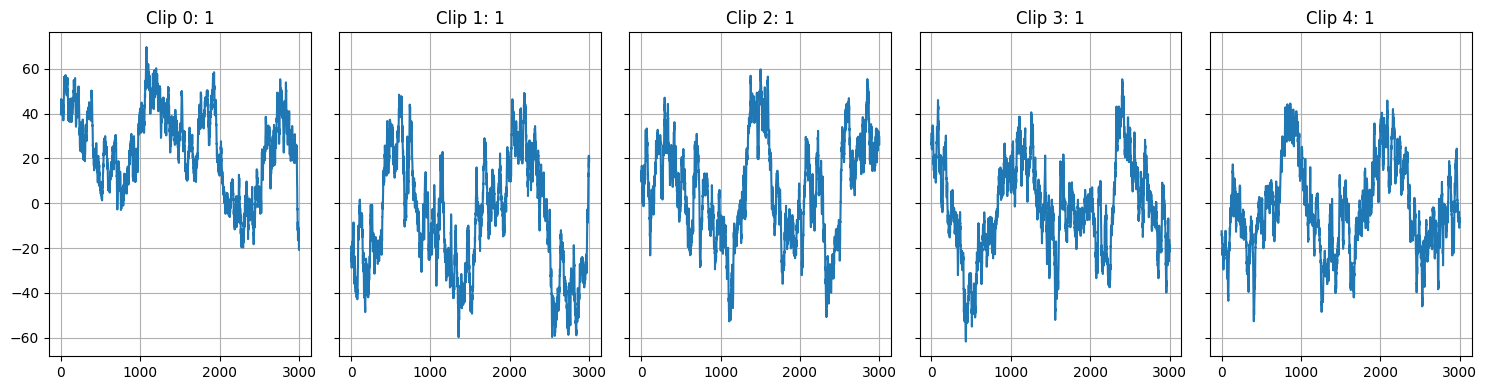

In [10]:
# compute diff of t and t + 1 of data
signals = x
x = np.diff(x, axis=0)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

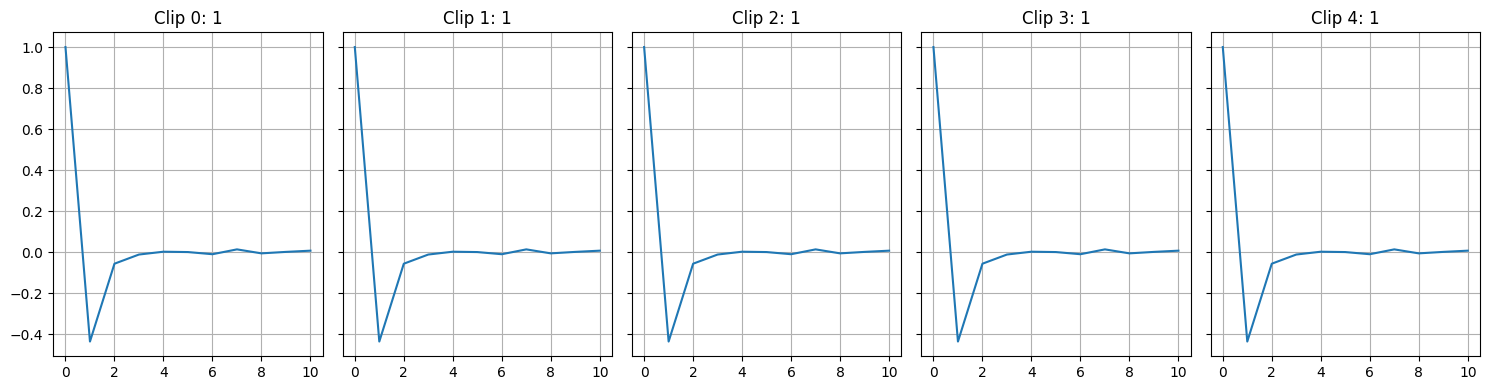

In [ ]:
# compute acf of each data and compute mean
from statsmodels.tsa.stattools import acf
def compute_acf(x: np.ndarray, lags: int = 100) -> np.ndarray:
    """
    Compute the autocorrelation function (ACF) of a signal.

    Parameters:
    - x: Input signal, shape (time, channels)
    - lags: Number of lags to compute

    Returns:
    - ACF values for each channel
    """
    acf_values = []
    for i in range(x.shape[1]):
        acf_values.append(acf(x[:, i], nlags=lags))
    mean_acf = np.mean(acf_values, axis=0)
    return mean_acf
lags = 10
mean_acf = compute_acf(x, lags=lags)
# plot acf
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(0, 1000 ,100):
    axes[i].plot(mean_acf)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()


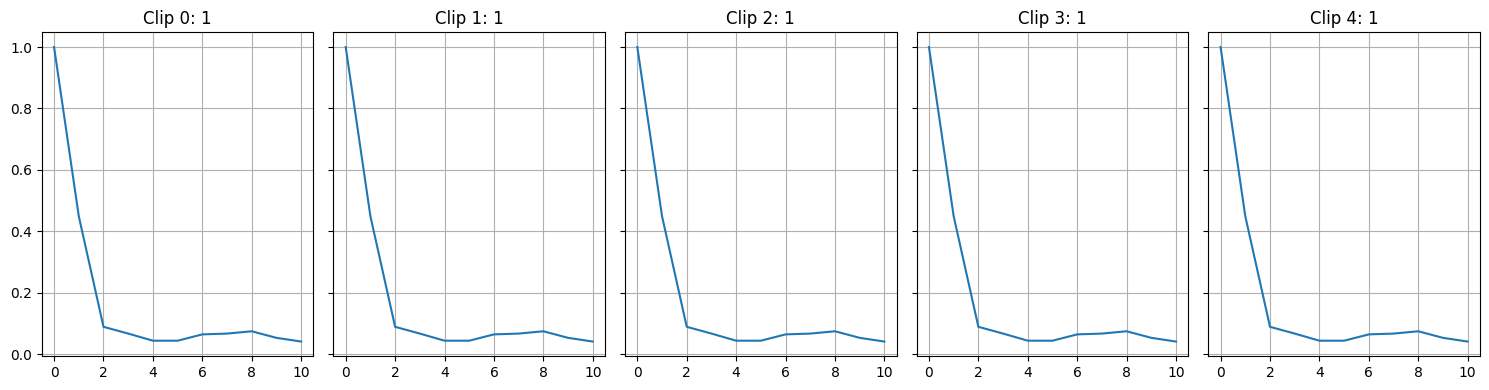

In [12]:
# compute acf volatility
x_squared = x ** 2
mean_acf_squared = compute_acf(x_squared, lags=lags)
# plot acf
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(mean_acf_squared)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

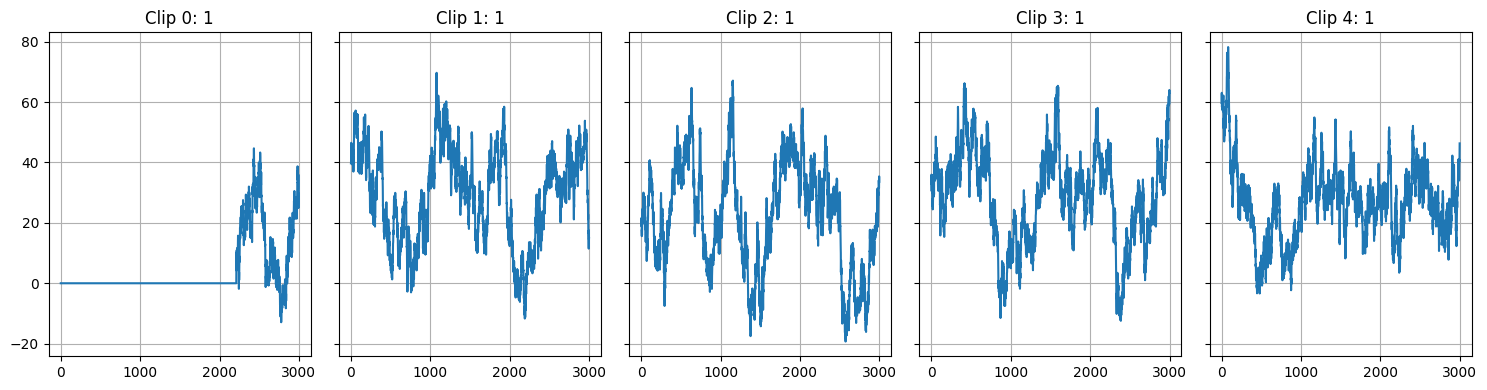

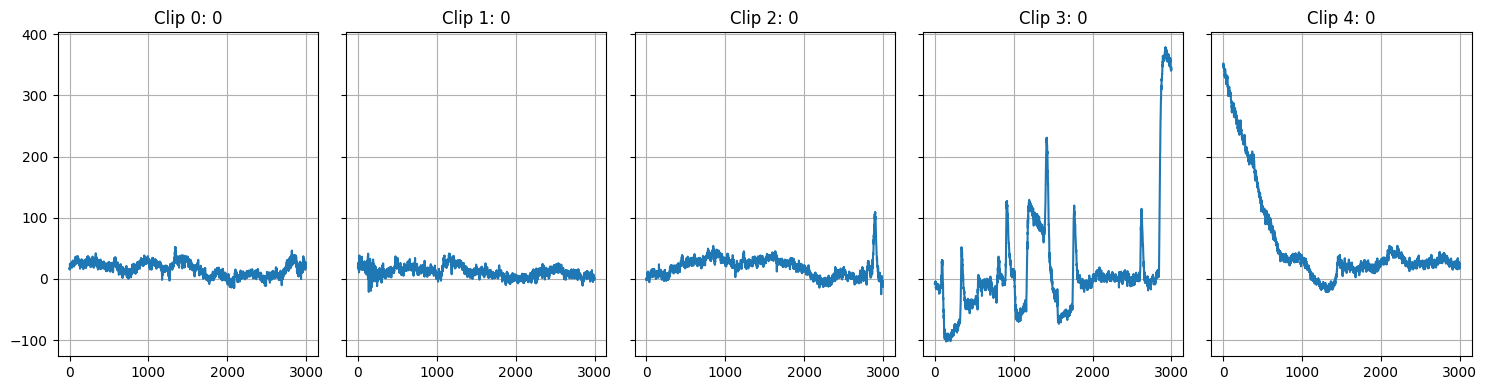

In [13]:
#plot signal label 1 and label 0
# get all signals with label 1
x_label_1 = signals[labels == 1]
# get all signals with label 0
x_label_0 = signals[labels == 0]
# plot first 5 signals with label 1
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_1[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 1"))
fig.tight_layout()
plt.show()
# plot first 5 signals with label 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_0[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 0"))
fig.tight_layout()
plt.show()

In [21]:
def compute_acf_integral(x: np.ndarray, lags: int = 100, n:int = 5) -> np.ndarray:
    acf_values_integrate = []
    for i in range(x.shape[1]):
        acf_value_to_integrate = acf(x[:, i], nlags=lags)
        #integrate first n values
        acf_value_to_integrate = np.trapz(acf_value_to_integrate[:n])
        acf_values_integrate.append(acf_value_to_integrate)
    print(acf_values_integrate)
    return acf_values_integrate
lags = 10
n = 3
# get signal with label 1
x_label_1 = signals[labels == 1]
# get signal with label 0
x_label_0 = signals[labels == 0]
# compute acf integral for label 1
mean_acf_integral_label_1 = compute_acf_integral(x_label_1**2, lags=lags, n=n)
# compute acf integral for label 0
mean_acf_integral_label_0 = compute_acf_integral(x_label_0**2, lags=lags, n=n)

/var/folders/dd/nv1lky5s1851076c3xc874p80000gn/T/ipykernel_69484/2808088967.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  acf_value_to_integrate = np.trapz(acf_value_to_integrate[:n])


[np.float64(0.8490072783431266), np.float64(0.9076095788925971), np.float64(0.879400501561615), np.float64(0.9769644747362477), np.float64(0.8726449048770839), np.float64(0.9137856846977512), np.float64(0.9186545686671177), np.float64(0.940928104363548), np.float64(0.8006982881399305), np.float64(0.5101311667772171), np.float64(0.5091979051711688), np.float64(0.5126992452943356), np.float64(0.5099568772567226), np.float64(0.5108350841063247), np.float64(0.5099720131230293), np.float64(0.5100424681601523), np.float64(0.510653287559399), np.float64(0.5091421159361887), np.float64(0.5098059359917905), np.float64(0.5090763367222534), np.float64(0.510439873066034), np.float64(0.5089448884456872), np.float64(0.5092816023769607), np.float64(0.5084619799892517), np.float64(0.50999048228957), np.float64(0.5088908709367179), np.float64(0.508772684966869), np.float64(0.5082074798585863), np.float64(0.5096653596517358), np.float64(0.5081218729108984), np.float64(0.5082406911912812), np.float64(0.5

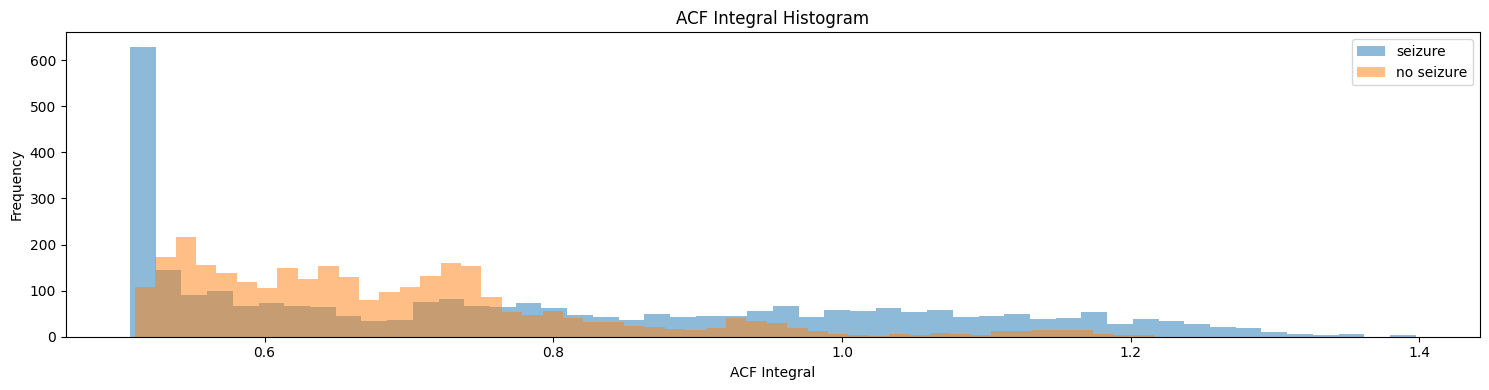

In [23]:
# plot histogram of acf integral for label 1 and label 0 in one plot
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.hist(mean_acf_integral_label_1, bins=50, alpha=0.5, label="seizure")
axes.hist(mean_acf_integral_label_0, bins=50, alpha=0.5, label="no seizure")
axes.set(title="ACF Integral Histogram", xlabel="ACF Integral", ylabel="Frequency")
axes.legend()
fig.tight_layout()
plt.show()

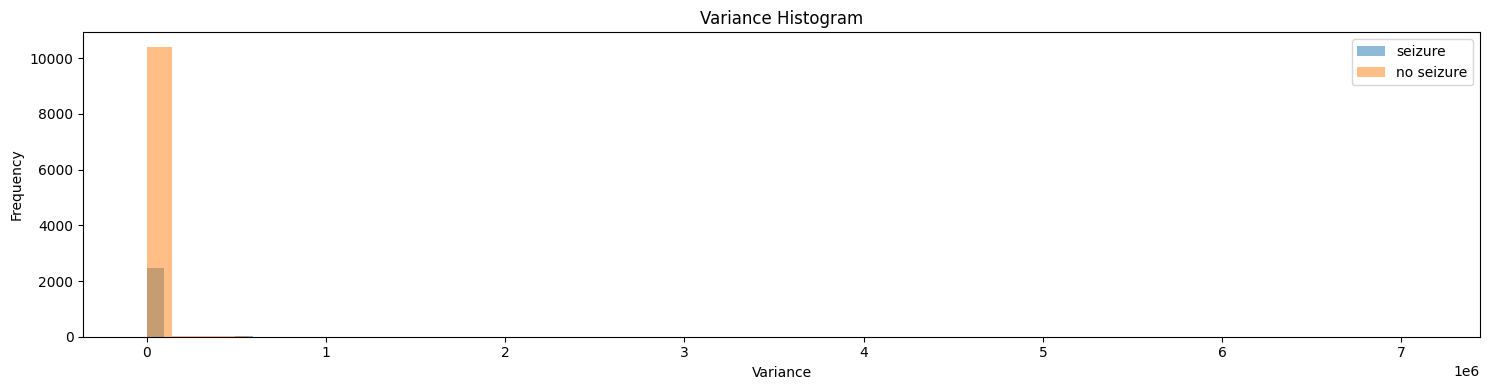

In [24]:
# plot variance of label 1 and label 0 in one plot
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.hist(np.var(x_label_1, axis=1), bins=50, alpha=0.5, label="seizure")
axes.hist(np.var(x_label_0, axis=1), bins=50, alpha=0.5, label="no seizure")
axes.set(title="Variance Histogram", xlabel="Variance", ylabel="Frequency")
axes.legend()
fig.tight_layout()
plt.show()

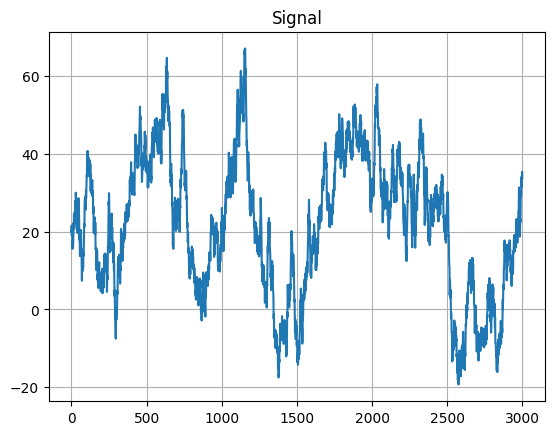

In [31]:
# take one signal
signal_train = signals[2]
# plot signal
plt.plot(signal_train)
plt.title("Signal")
plt.grid()
plt.show()

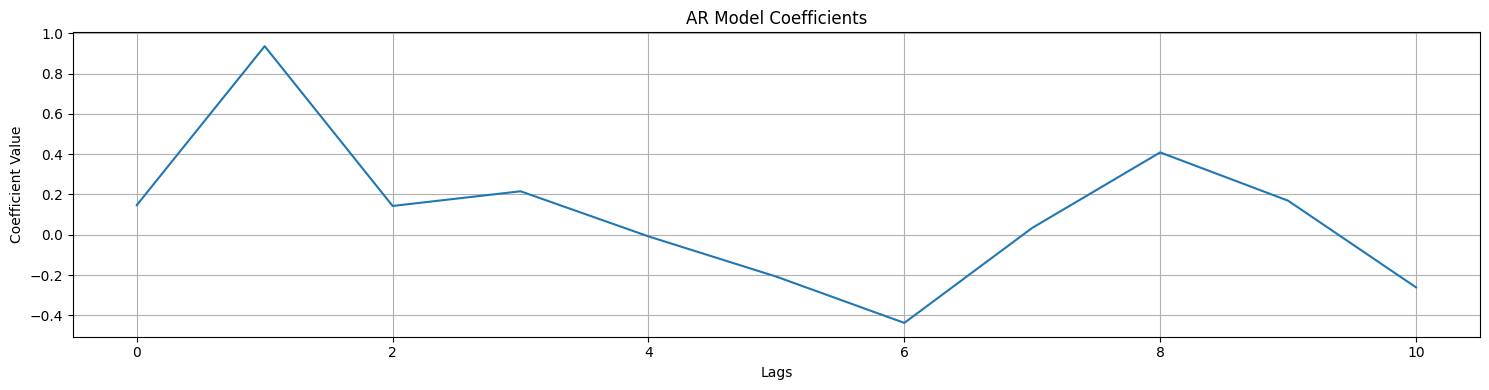

In [32]:
# fit AR model
from statsmodels.tsa.ar_model import AutoReg

def fit_ar_model(signal: np.ndarray, lags: int = 10) -> np.ndarray:
    """
    Fit an AR model to the signal and return the coefficients.

    Parameters:
    - signal: Input signal, shape (time, channels)
    - lags: Number of lags to use in the AR model

    Returns:
    - AR coefficients for each channel
    """
    ar_model = AutoReg(signal, lags=lags)
    ar_model_fit = ar_model.fit()
    return ar_model_fit.params
lags = 10
# fit ar model to signal
ar_model_fit = fit_ar_model(signal_train, lags=lags)
# plot ar model coefficients
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.plot(ar_model_fit)
axes.set(title="AR Model Coefficients", xlabel="Lags", ylabel="Coefficient Value")
axes.grid()
fig.tight_layout()
plt.show()

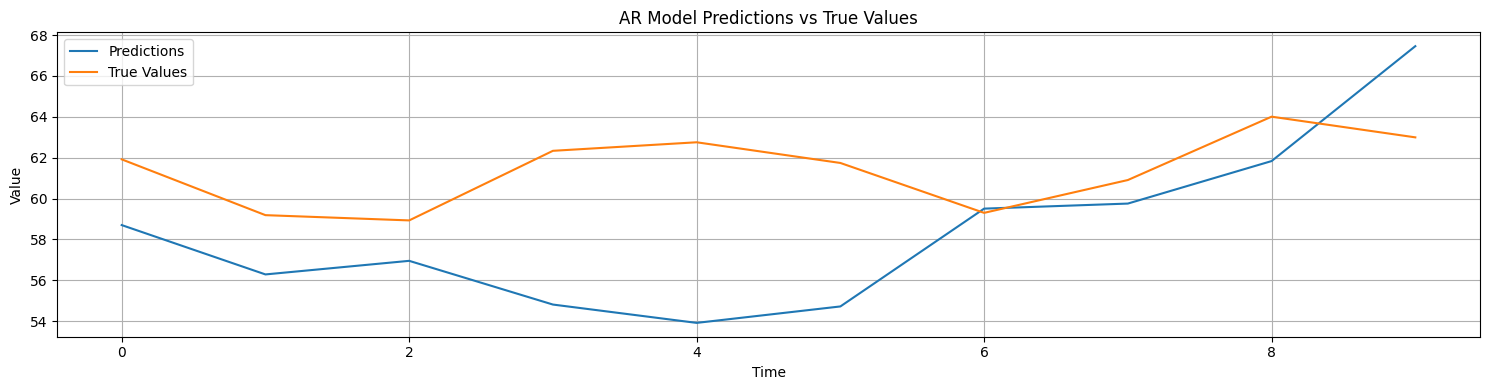

In [35]:
# recursively predict 10 steps ahead
def predict_ar_model(ar_model_fit: np.ndarray, signal: np.ndarray, steps: int = 10) -> np.ndarray:
    """
    Predict future values using the AR model.

    Parameters:
    - ar_model_fit: Fitted AR model coefficients
    - signal: Input signal, shape (time, channels)
    - steps: Number of steps to predict

    Returns:
    - Predicted values
    """
    predictions = []
    for i in range(steps):
        prediction = np.dot(ar_model_fit, signal[-(lags + 1):])
        predictions.append(prediction)
        signal = np.append(signal, prediction)
    return np.array(predictions)
steps = 10
signal_test = signals[3]
# save last 10 values of signal
signal_test_last = signal_test[-steps:]
# remove last 10 values from signal
signal_test = signal_test[:-steps]
# predict 10 steps ahead
predictions = predict_ar_model(ar_model_fit, signal_test, steps=steps)
# plot predictions vs true values
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.plot(predictions, label="Predictions")
axes.plot(signal_test_last, label="True Values")
axes.set(title="AR Model Predictions vs True Values", xlabel="Time", ylabel="Value")
axes.legend()
axes.grid()
fig.tight_layout()
plt.show()

In [39]:
# fit ar model to all signals
ar_model_fits_label_1 = []
ar_model_fits_label_0 = []
for i in range(len(x_label_0)):
    ar_model_fit = fit_ar_model(x_label_0[i], lags=lags)
    ar_model_fits_label_0.append(ar_model_fit)
for i in range(len(x_label_1)):
    ar_model_fit = fit_ar_model(x_label_1[i], lags=lags)
    ar_model_fits_label_1.append(ar_model_fit)


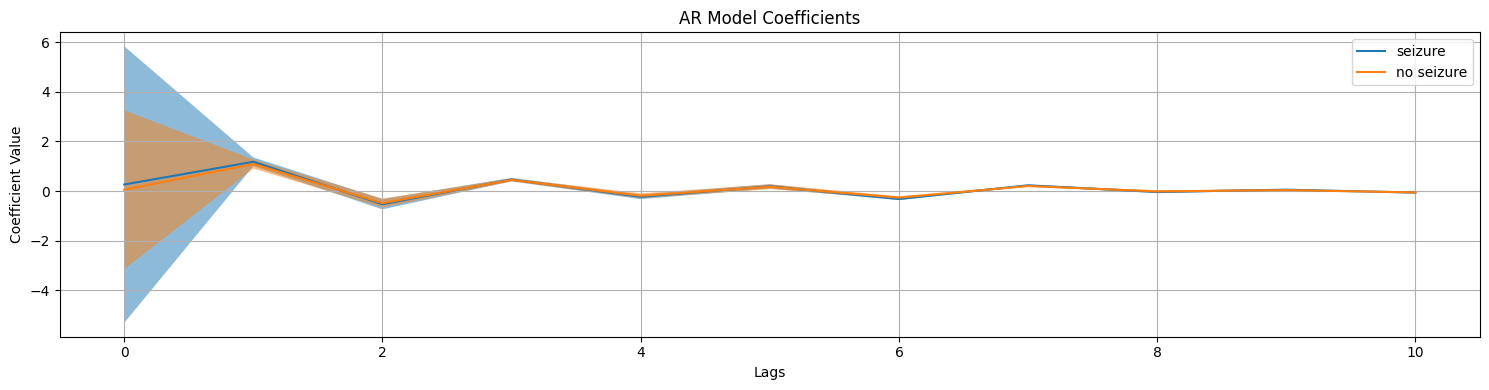

In [40]:
# get mean and variance of ar model coefficients for label 1 and label 0
mean_ar_model_fit_label_1 = np.mean(ar_model_fits_label_1, axis=0)
mean_ar_model_fit_label_0 = np.mean(ar_model_fits_label_0, axis=0)
# get variance of ar model coefficients for label 1 and label 0
var_ar_model_fit_label_1 = np.var(ar_model_fits_label_1, axis=0)
var_ar_model_fit_label_0 = np.var(ar_model_fits_label_0, axis=0)
# plot mean and variance of ar model coefficients for label 1 and label 0
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.plot(mean_ar_model_fit_label_1, label="seizure")
axes.plot(mean_ar_model_fit_label_0, label="no seizure")
axes.fill_between(
    np.arange(len(mean_ar_model_fit_label_1)),
    mean_ar_model_fit_label_1 - var_ar_model_fit_label_1,
    mean_ar_model_fit_label_1 + var_ar_model_fit_label_1,
    alpha=0.5,
)
axes.fill_between(
    np.arange(len(mean_ar_model_fit_label_0)),
    mean_ar_model_fit_label_0 - var_ar_model_fit_label_0,
    mean_ar_model_fit_label_0 + var_ar_model_fit_label_0,
    alpha=0.5,
)
axes.set(title="AR Model Coefficients", xlabel="Lags", ylabel="Coefficient Value")
axes.legend()
axes.grid()
fig.tight_layout()
plt.show()

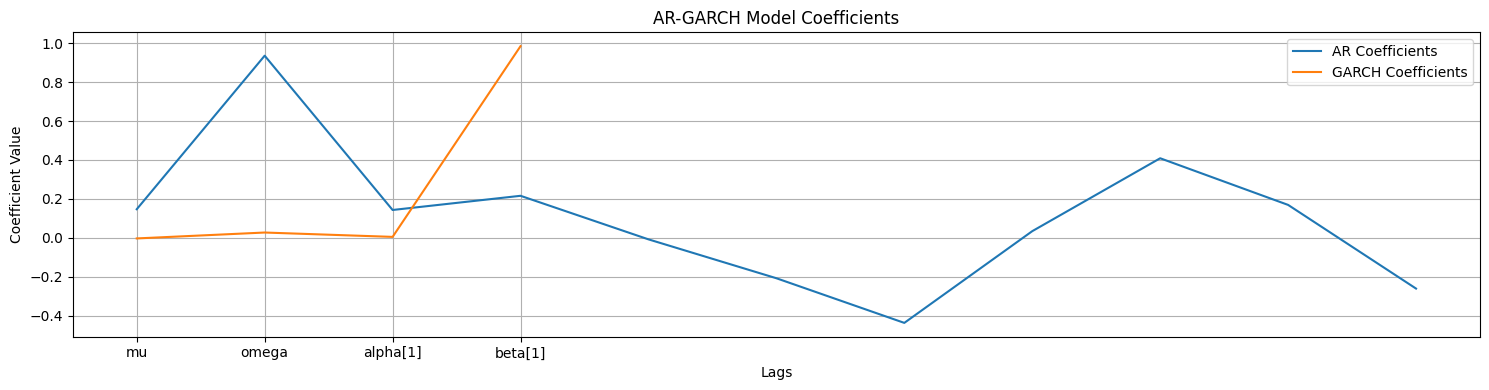

In [41]:
signal_train = signals[2]
# fit and ar garch model
from arch import arch_model
def fit_ar_garch_model(signal: np.ndarray, lags: int = 10, q: int = 1, p: int = 1) -> np.ndarray:
    """
    Fit an AR-GARCH model to the signal and return the coefficients.

    Parameters:
    - signal: Input signal, shape (time, channels)
    - lags: Number of lags to use in the AR model
    - q: Number of lags to use in the GARCH model
    - p: Number of lags to use in the GARCH model

    Returns:
    - AR-GARCH model coefficients for each channel
    """
    # fit ar model
    ar_model = AutoReg(signal, lags=lags)
    ar_model_fit = ar_model.fit()
    # get residuals
    residuals = ar_model_fit.resid
    # fit garch model
    garch_model = arch_model(residuals, vol="Garch", p=p, q=q)
    garch_model_fit = garch_model.fit(disp="off")
    return ar_model_fit.params, garch_model_fit.params
lags = 10
q = 1
p = 1
# fit ar garch model to signal
ar_garch_model_fit = fit_ar_garch_model(signal_train, lags=lags, q=q, p=p)
# plot ar garch model coefficients
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.plot(ar_garch_model_fit[0], label="AR Coefficients")
axes.plot(ar_garch_model_fit[1], label="GARCH Coefficients")
axes.set(title="AR-GARCH Model Coefficients", xlabel="Lags", ylabel="Coefficient Value")
axes.legend()
axes.grid()
fig.tight_layout()
plt.show()

In [42]:
# fit ar garch model to all signals
ar_garch_model_fits_label_1 = []
ar_garch_model_fits_label_0 = []
for i in range(len(x_label_0)):
    ar_garch_model_fit = fit_ar_garch_model(x_label_0[i], lags=lags, q=q, p=p)
    ar_garch_model_fits_label_0.append(ar_garch_model_fit)
for i in range(len(x_label_1)):
    ar_garch_model_fit = fit_ar_garch_model(x_label_1[i], lags=lags, q=q, p=p)
    ar_garch_model_fits_label_1.append(ar_garch_model_fit)

/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/arch/univariate/volatility.py:1215: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/arch/univariate/distribution.py:449: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/arch/univariate/distribution.py:449: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/arch/univariate/distribution.py:449: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-package

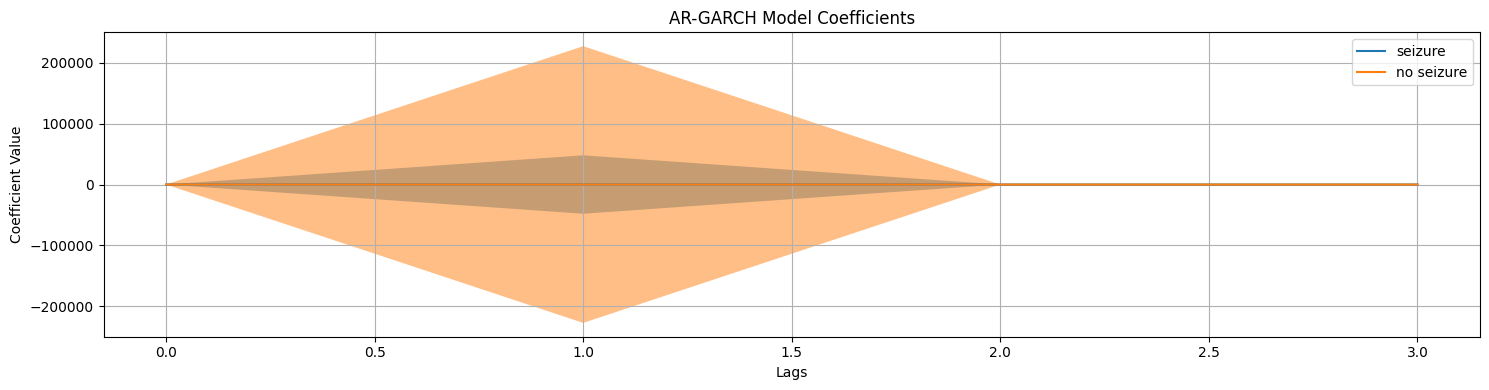

### Frequency Analysis


In [6]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

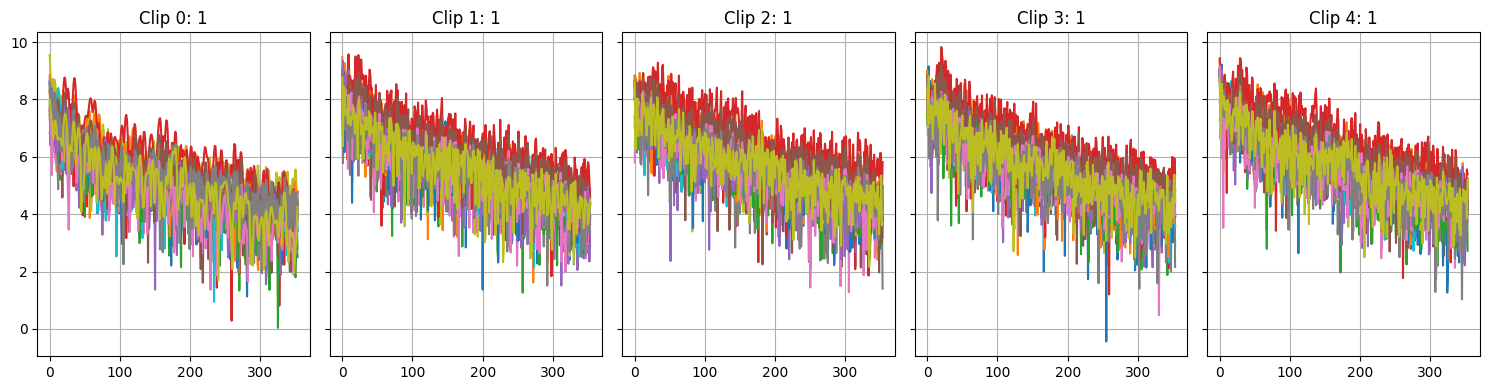

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

In [8]:
# print the shape of the dataset
print(f"Dataset shape: {dataset_tr.__len__()}")
# print the shape of the first 10 clips
for i in range(10):
    x, y = dataset_tr[i]
    print(f"Clip {i} shape: {x.shape}, label: {y}")

Dataset shape: 12993
Clip 0 shape: (354, 19), label: 1
Clip 1 shape: (354, 19), label: 1
Clip 2 shape: (354, 19), label: 1
Clip 3 shape: (354, 19), label: 1
Clip 4 shape: (354, 19), label: 1
Clip 5 shape: (354, 19), label: 1
Clip 6 shape: (354, 19), label: 1
Clip 7 shape: (354, 19), label: 1
Clip 8 shape: (354, 19), label: 1
Clip 9 shape: (354, 19), label: 1


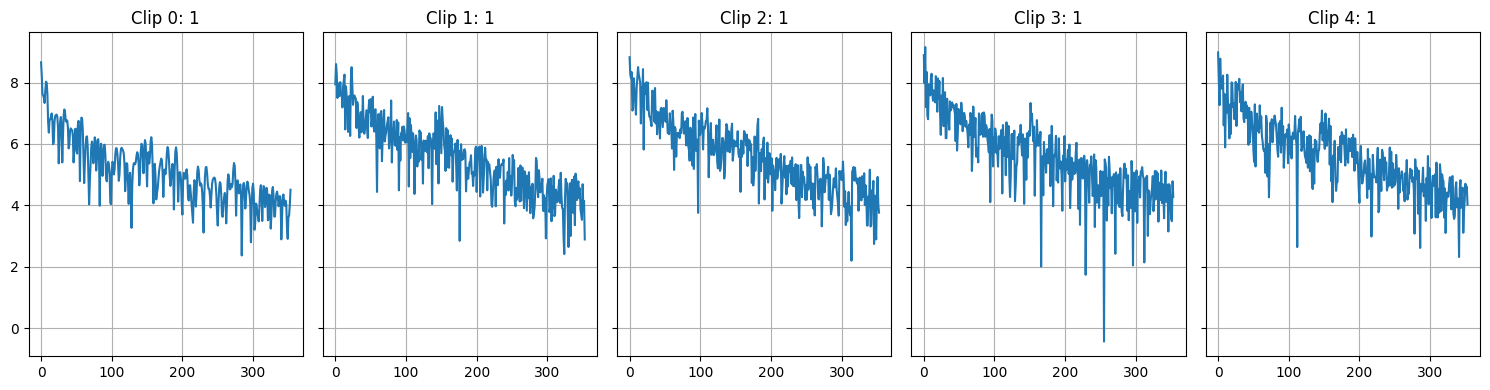

In [9]:
x = []
labels = []
for i in range(len(dataset_tr)):
    clip, y = dataset_tr[i]
    x.append(clip[:, 0])
    labels.append(y)
x = np.array(x)
labels = np.array(labels)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

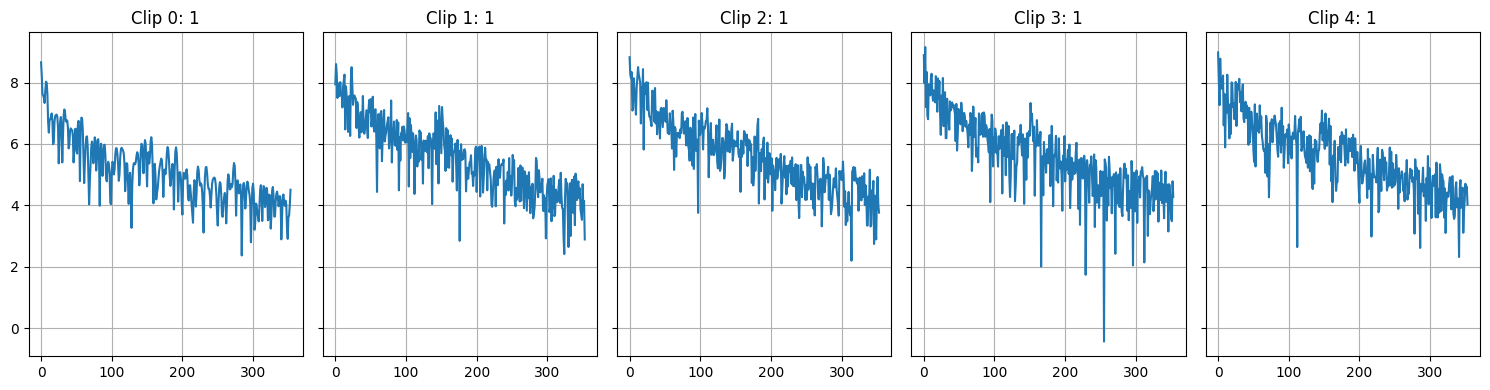

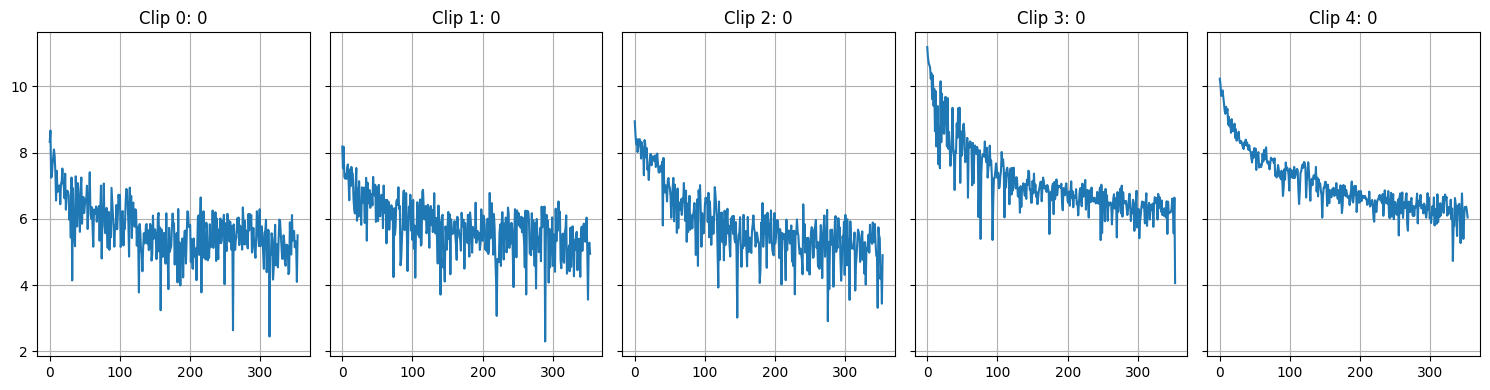

In [10]:
#plot signal label 1 and label 0
# get all signals with label 1
x_label_1 = x[labels == 1]
# get all signals with label 0
x_label_0 = x[labels == 0]
# plot first 5 signals with label 1
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_1[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 1"))
fig.tight_layout()
plt.show()
# plot first 5 signals with label 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_0[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 0"))
fig.tight_layout()
plt.show()

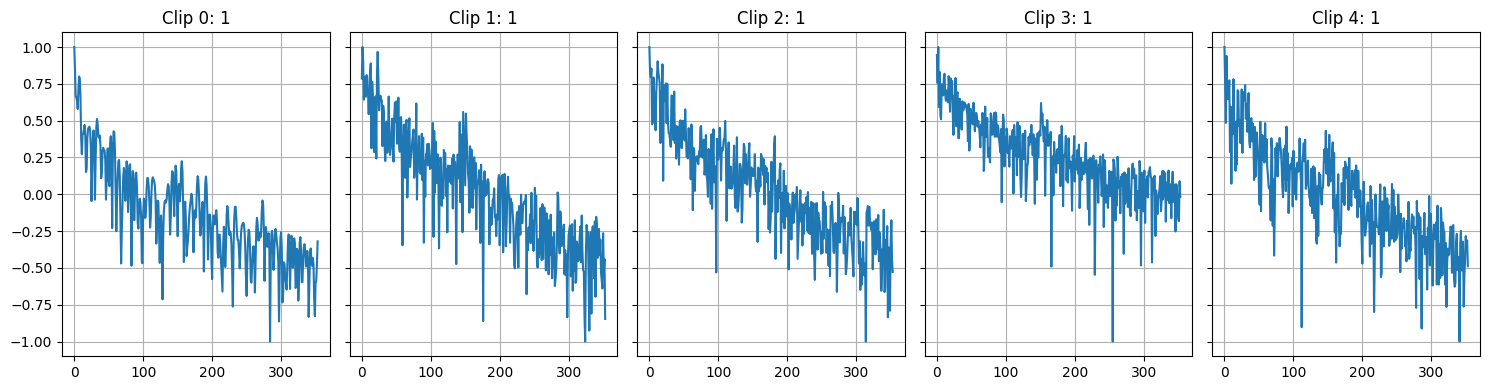

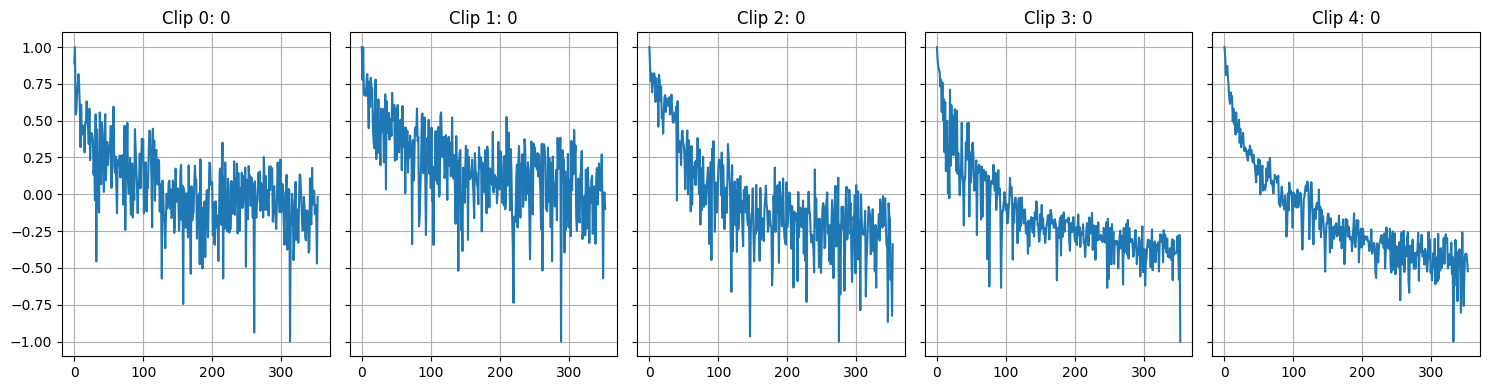

In [11]:
# normalize each clips
x_normalized = []
for i in range(len(x)):
    x_normalized.append(normalize_eeg(x[i]))

x_normalized = np.array(x_normalized)
x_normalized_label_1 = x_normalized[labels == 1]
x_normalized_label_0 = x_normalized[labels == 0]
# plot first 5 signals with label 1
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_normalized_label_1[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 1"))
fig.tight_layout()
plt.show()
# plot first 5 signals with label 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_normalized_label_0[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 0"))
fig.tight_layout()
plt.show()

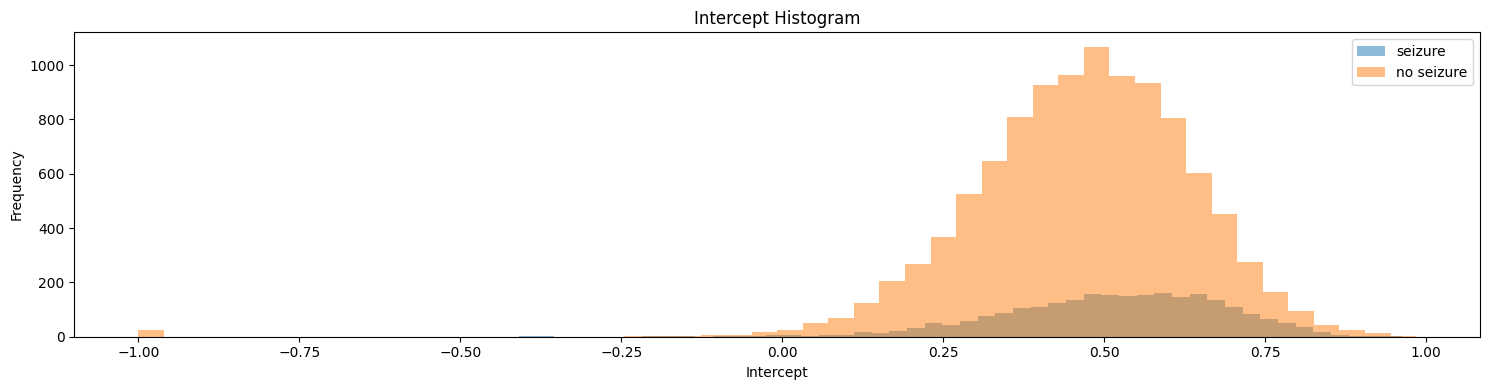

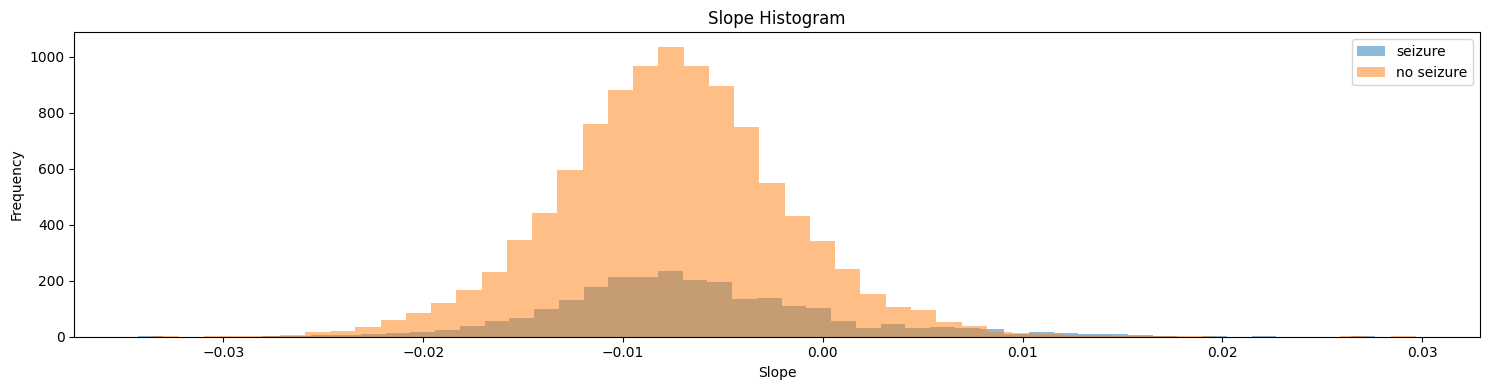

In [17]:
# perform linear regression on the normalized data label 1 and label 0
from sklearn.linear_model import LinearRegression

x_normalized_label_0 =x_normalized[labels == 0] 
x_normalized_label_1 = x_normalized[labels == 1]


x_normalized_label_1 = x_normalized_label_1[:,20:50]
x_normalized_label_0 = x_normalized_label_0[:,20:50]


# fit linear regression to label 1
x_values = np.arange(0,len(x_normalized_label_1[0]))
y = x_normalized_label_1[0]
linear_reg = LinearRegression()
linear_reg.fit(x_values.reshape(-1, 1), y)

intercept_label_1 = []
slope_label_1 = []

for i in range(1, len(x_normalized_label_1)):
    model = linear_reg.fit(x_values.reshape(-1, 1), x_normalized_label_1[i])
    intercept = model.intercept_ 
    slope = model.coef_[0] 
    intercept_label_1.append(intercept)
    slope_label_1.append(slope)
# fit linear regression to label 0
x_values = np.arange(0,len(x_normalized_label_0[0]))
y = x_normalized_label_0[0]
linear_reg = LinearRegression()
linear_reg.fit(x_values.reshape(-1, 1), y)
intercept_label_0 = []
slope_label_0 = []
for i in range(1, len(x_normalized_label_0)):
    model = linear_reg.fit(x_values.reshape(-1, 1), x_normalized_label_0[i])
    intercept = model.intercept_ 
    slope = model.coef_[0] 
    intercept_label_0.append(intercept)
    slope_label_0.append(slope)
# plot dist of intercept for label 1 and label 0
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.hist(intercept_label_1, bins=50, alpha=0.5, label="seizure")
axes.hist(intercept_label_0, bins=50, alpha=0.5, label="no seizure")
axes.set(title="Intercept Histogram", xlabel="Intercept", ylabel="Frequency")
axes.legend()
fig.tight_layout()
plt.show()
# plot dist of slope for label 1 and label 0
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.hist(slope_label_1, bins=50, alpha=0.5, label="seizure")
axes.hist(slope_label_0, bins=50, alpha=0.5, label="no seizure")
axes.set(title="Slope Histogram", xlabel="Slope", ylabel="Frequency")
axes.legend()
fig.tight_layout()
plt.show()
